In [1]:
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
# import ardent
import time
import os
import pandas as pd

# from proglearn.progressive_learner import ProgressiveLearner
# from proglearn.deciders import SimpleArgmaxAverage
# from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
# from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from proglearn.sims.gaussian_sim import _generate_2d_rotation
from proglearn.sims import generate_spirals
from proglearn.forest import LifelongClassificationForest

import pandas as pd
import SimpleITK as sitk
from sklearn.neighbors import BallTree

In [2]:
context = sns.plotting_context(context="talk", font_scale=1)
sns.set_context(context)

In [3]:
def grid_to_pred(task_pos_reshaped, test_task, xx, yy):
    pred = np.empty((len(test_task), ))

    for i in range(len(test_task)):
        x_ind = np.where(test_task[i,0] <= xx[0,:])[0][0]
        y_ind = np.where(test_task[i,1] <= yy[:,0])[0][0]
        pred[i] = task_pos_reshaped[y_ind, x_ind]

    pred = pred.reshape((-1,1))
    pred = np.hstack((pred, 1-pred))
    pred = np.argmax(pred, axis=1)
    
    return pred

In [4]:
def rotated_spirals(n_samples, n_class=2, noise=0.3, angle=0):
    X,y = generate_spirals(n_samples=n_samples, n_class=n_class, noise=noise)
    if angle is not 0:
        R = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
        X = X @ R
    return X, y

In [5]:
radius = 1.2
def to_grid_in_cir(test_task1, test_task2, radius=radius):
    h = 0.01
    x_min1, x_max1 = test_task1[:,0].min(), test_task1[:,0].max()
    y_min1, y_max1 = test_task1[:,1].min(), test_task1[:,1].max()
    x_min2, x_max2 = test_task2[:,0].min(), test_task2[:,0].max()
    y_min2, y_max2 = test_task2[:,1].min(), test_task2[:,1].max()

    x_min = min(x_min1, x_min2) - 0.1
    x_max = max(x_max1, x_max2) + 0.1
    y_min = min(y_min1, y_min2) - 0.1
    y_max = max(y_max1, y_max2) + 0.1
    x, y = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    r = np.sqrt(x**2 + y**2)  # centered at (0,0)
    inside = r <= radius  # radius of 1
    x_cir = x[inside]  # can also use np.ma.masked_less_equal(r,1).data
    y_cir = y[inside]
    return x, y, inside, np.array([x_cir, y_cir]).T

In [6]:
def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

In [64]:
# def init_forest(max_depth):
#     np.random.seed(1)
#     default_transformer_class = TreeClassificationTransformer
#     default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

#     default_voter_class = TreeClassificationVoter
#     default_voter_kwargs = {}

#     default_decider_class = SimpleArgmaxAverage
#     default_decider_kwargs = {"classes" : np.arange(2)}
#     progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
#                                             default_transformer_kwargs = default_transformer_kwargs,
#                                             default_voter_class = default_voter_class,
#                                             default_voter_kwargs = default_voter_kwargs,
#                                             default_decider_class = default_decider_class,
#                                             default_decider_kwargs = default_decider_kwargs)
#     uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
#                                             default_transformer_kwargs = default_transformer_kwargs,
#                                             default_voter_class = default_voter_class,
#                                             default_voter_kwargs = default_voter_kwargs,
#                                             default_decider_class = default_decider_class,
#                                             default_decider_kwargs = default_decider_kwargs)
#     return progressive_learner, uf

In [7]:
def generate_posteriors(X, task_id, forest, transformers):
    vote_per_transformer_id = []
    for transformer_id in transformers:
        vote_per_bag_id = []
        for bag_id in range(
            len(forest.pl_.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id])
        ):
            transformer = forest.pl_.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id][
                bag_id
            ]
            X_transformed = transformer.transform(X)
            voter = forest.pl_.task_id_to_decider[task_id].transformer_id_to_voters_[transformer_id][bag_id]
            vote = voter.predict_proba(X_transformed)
            vote_per_bag_id.append(vote)
        vote_per_transformer_id.append(np.mean(vote_per_bag_id, axis=0))

    return vote_per_transformer_id

In [8]:
def box_to_cir(data, radius=radius):
    X = data[0]
    y = data[1]
    X_cir = []
    y_cir = []
    for i in range(len(X)):
        if (X[i,0]**2 + X[i,1]**2 <= radius):
            X_cir.append(X[i,:])
            y_cir.append(y[i])
    return np.array(X_cir).reshape(-1,2), np.array(y_cir).reshape(-1)

In [127]:
def run_elastix(task1pred1_reshaped, task2pred2_reshaped, metric, ite):
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(task1pred1_reshaped))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(task2pred2_reshaped))
    elastixImageFilter.LogToFileOn()
    ParamMap = sitk.GetDefaultParameterMap('affine')    
    ParamMap['AutomaticTransformInitialization'] = ['false']
    ParamMap['AutomaticTransformInitializationMethod'] = ['GeometricalCenter']
    ParamMap['Metric'] = [metric]
    ParamMap['MaximumNumberOfIterations'] = [ite]
    
#     ParamMap['MaximumNumberOfSamplingAttempts'] = ['4']
#     ParamMap['AutomaticScalesEstimation'] = ['false']
#     ParamMap['UseRandomSampleRegion'] = ['true']
#     ParamMap['SampleRegionSize'] = ['100','100']
#     ParamMap['MaximumNumberOfSamplingAttempts'] = ['10']
#     ParamMap['MaximumStepLength'] = ['0.5']
#     ParamMap['AutomaticParameterEstimation'] = ['false']
    ParamMap['Transform'] = ['EulerTransform']
#     ParamMap['AutomaticTransformInitialization'] = ['true']
    ParamMap['NumberOfResolutions'] = ['4']
    ParamMap['MaximumStepLength'] = ['1.0']
    ParamMap['ImageSampler'] = ['Random']
    ParamMap['SP_alpha'] = ['0.6']
    ParamMap['SP_A'] = ['50']
    ParamMap['NewSamplesEveryIteration'] = ['true']
    ParamMap['FixedImagePyramid'] = ['FixedRecursiveImagePyramid']
    ParamMap["MovingImagePyramid"] = ["MovingRecursiveImagePyramid"] 
    ParamMap['UseDirectionCosines'] = ['true']
    
    ParamMap['Scales'] = ['100.0']
    ParamMap['AutomaticScalesEstimation'] = ['false']
#     ParamMap['BSplineInterpolationOrder'] = ['3']

    # Set the parameter map:
    elastixImageFilter.SetParameterMap(ParamMap)

    # Register the 2D images:
    elastixImageFilter.Execute()

    # Get the registered image:
    RegIm = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
#     params = elastixImageFilter.GetTransformParameterMap()[0]["TransformParameters"]
    
    return RegIm

In [10]:
def params_to_mat(params):
    init_affines = np.eye(3)
    init_affines[0,:2] = [float(params[0]), float(params[2])]
    init_affines[1,:2] = [float(params[1]), float(params[3])]
    init_affines[2,:2] = [float(params[4]), float(params[5])]
    return init_affines.T

In [11]:
def reshape_posteriors(inside, task):
    inside_ravel = inside.ravel()
    preds = np.zeros(inside_ravel.shape)
    j = 0
    for i in range(len(inside_ravel)):
        if inside_ravel[i]:
            preds[i] = task[j]
            j += 1
    preds = preds.reshape(inside.shape)
    
    return preds

In [12]:
def vote_to_pred(vote, test_task, test_grid):
    tree = BallTree(test_grid)
    pred = np.zeros(test_task.shape)
    for i in range(len(test_task)):
        _, ind = tree.query(test_task[i,:].reshape(-1,2), k=1)
        pred[i,0] = vote[ind]
        pred[i,1] = 1 - pred[i,0]
        
    return pred

#### compute errors

In [13]:
def exp(n_task1, n_task2, task2_angle, task1_angle=0, n_test=1000, n_trees=10, ite=500):
    #source data
    X_task1, y_task1 = box_to_cir(rotated_spirals(n_task1, 2, 0.8, task1_angle))
    test_task1, test_label_task1 = box_to_cir(rotated_spirals(n_test, 2, 0.8, task1_angle))

    #target data
    X_task2, y_task2 = box_to_cir(rotated_spirals(n_task2, 2, 0.8, task2_angle))
    test_task2, test_label_task2 = box_to_cir(rotated_spirals(n_test,  2, 0.8, task2_angle))
    xx, yy, inside, test_grid = to_grid_in_cir(test_task1, test_task2)

    l2f = LifelongClassificationForest(default_n_estimators=n_trees)
    uf1 = LifelongClassificationForest(default_n_estimators=n_trees)

    l2f.add_task(X_task1, y_task1, n_estimators=n_trees)
    l2f.add_task(X_task2, y_task2, n_estimators=n_trees)
    uf1.add_task(X_task1, y_task1, n_estimators=2*n_trees)

    l2f_task1 = generate_posteriors(test_grid, 0, l2f, [0,1])
    l2f_task2 = generate_posteriors(test_grid, 1, l2f, [0,1])

    task1pred1_reshaped = reshape_posteriors(inside, l2f_task1[0][:,0])
    task1pred2_reshaped = reshape_posteriors(inside, l2f_task1[1][:,0])
    task2pred1_reshaped = reshape_posteriors(inside, l2f_task2[0][:,0])
    task2pred2_reshaped = reshape_posteriors(inside, l2f_task2[1][:,0])

    uf_task1 = generate_posteriors(test_grid, 0, uf1, [0])
    task1pred1_reshaped_uf = reshape_posteriors(inside, uf_task1[0][:,0])

    errors = np.zeros(3, dtype=float)
    vote1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)[inside].ravel()
    pred1 = vote_to_pred(vote1, test_task1, test_grid)
    errors[0] = 1-np.mean(np.argmax(pred1, axis=1) == test_label_task1)

    vote3 = task1pred1_reshaped_uf[inside].ravel()
    pred3 = vote_to_pred(vote3, test_task1, test_grid)
    errors[2] = 1-np.mean(np.argmax(pred3, axis=1) == test_label_task1)
    
    try:
        # run elastix
        task1pred1_deformed = run_elastix(
                task1pred1_reshaped, task2pred2_reshaped, 'AdvancedNormalizedCorrelation', str(ite)
            )

        vote2 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)[inside].ravel()
        pred2 = vote_to_pred(vote2, test_task1, test_grid)
        errors[1] = 1-np.mean(np.argmax(pred2, axis=1) == test_label_task1)
    except:
        errors[1] = np.nan
    
    return errors

In [15]:
exp(750, 750, task2_angle=np.pi*(165/180), ite=1000)

array([0.081, 0.188, 0.092])

In [123]:
n_task1=750; n_task2=750; n_test=1000; n_trees=10; task2_angle=np.pi*(30/180); task1_angle=0
errors=np.zeros(3, dtype=float)

#source data
X_task1, y_task1 = box_to_cir(rotated_spirals(n_task1, 2, 0.8, task1_angle))
test_task1, test_label_task1 = box_to_cir(rotated_spirals(n_test, 2, 0.8, task1_angle))

#target data
X_task2, y_task2 = box_to_cir(rotated_spirals(n_task2, 2, 0.8, task2_angle))
test_task2, test_label_task2 = box_to_cir(rotated_spirals(n_test,  2, 0.8, task2_angle))
xx, yy, inside, test_grid = to_grid_in_cir(test_task1, test_task2)

l2f = LifelongClassificationForest(default_n_estimators=n_trees)
uf1 = LifelongClassificationForest(default_n_estimators=n_trees)

l2f.add_task(X_task1, y_task1, n_estimators=n_trees)
l2f.add_task(X_task2, y_task2, n_estimators=n_trees)
uf1.add_task(X_task1, y_task1, n_estimators=2*n_trees)

l2f_task1 = generate_posteriors(test_grid, 0, l2f, [0,1])
l2f_task2 = generate_posteriors(test_grid, 1, l2f, [0,1])

task1pred1_reshaped = reshape_posteriors(inside, l2f_task1[0][:,0])
task1pred2_reshaped = reshape_posteriors(inside, l2f_task1[1][:,0])
task2pred1_reshaped = reshape_posteriors(inside, l2f_task2[0][:,0])
task2pred2_reshaped = reshape_posteriors(inside, l2f_task2[1][:,0])

uf_task1 = generate_posteriors(test_grid, 0, uf1, [0])
task1pred1_reshaped_uf = reshape_posteriors(inside, uf_task1[0][:,0])

errors = np.zeros(3, dtype=float)
vote1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)[inside].ravel()
pred1 = vote_to_pred(vote1, test_task1, test_grid)
errors[0] = 1-np.mean(np.argmax(pred1, axis=1) == test_label_task1)

vote3 = task1pred1_reshaped_uf[inside].ravel()
pred3 = vote_to_pred(vote3, test_task1, test_grid)
errors[2] = 1-np.mean(np.argmax(pred3, axis=1) == test_label_task1)

In [126]:
# run elastix
task1pred1_deformed = run_elastix(
        task1pred1_reshaped, task2pred2_reshaped, 'AdvancedNormalizedCorrelation', '1500'
    )
vote2 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)[inside].ravel()
pred2 = vote_to_pred(vote2, test_task1, test_grid)
errors[1] = 1-np.mean(np.argmax(pred2, axis=1) == test_label_task1)
errors

array([0.091, 0.083, 0.105])

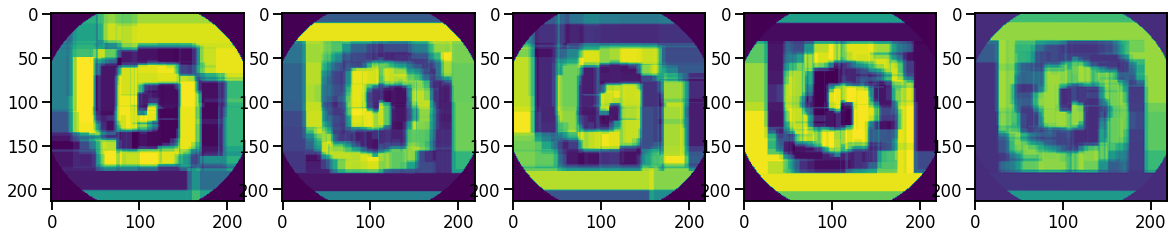

In [71]:
fig,axs = plt.subplots(1,5,figsize=(20,4))
axs[0].imshow(task1pred1_reshaped)
axs[1].imshow(task1pred2_reshaped)
axs[2].imshow(task2pred1_reshaped)
axs[3].imshow(task2pred2_reshaped)
axs[4].imshow(task1pred1_deformed)
# plt.colorbar()
plt.show()

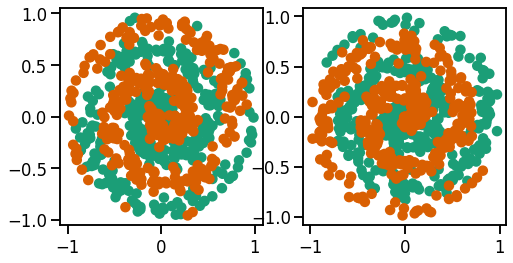

In [94]:
colors = sns.color_palette('Dark2', n_colors=5)
clr = [colors[i] for i in y_task1]
fig,axs = plt.subplots(1,2,figsize=(8,4))
axs[0].scatter(X_task1[:,0],X_task1[:,1], c=clr)
axs[1].scatter(X_task2[:,0],X_task2[:,1], c=clr)

#### run experiment

In [ ]:
start_time = time.time()
print(exp(100,100,7, task1_angle=np.pi*(15/180), task2_angle=np.pi*(65/180), ite=1000))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
rep = 1000
angle1 = 0
angle2 = 60
errors_0_75 = Parallel(n_jobs=-2, verbose=1)(
    delayed(exp)(
        100, 100, ceil(log2(100)), task1_angle=np.pi*(angle1/180), task2_angle=np.pi*(angle2/180), ite=1000
    ) for _ in range(rep)
)

In [ ]:
[np.mean(np.array(errors_0_75)[:,i]) for i in range(3)]

In [ ]:
for i in [0,1]:
    print(np.mean(np.array(errors_0_75)[:,2]) / np.mean(np.array(errors_0_75)[:,i]))

In [130]:
errors_all = {}
# pickle_in = open("errors_all-spiral-sitk-angles0_15_90-0216.pickle", "rb")
# errors_all = pickle.load(pickle_in)

In [147]:
rep = 1000
angle1 = 0
# angle2 = [0, 15, 30, 45, 60, 75, 90]
angle2 = [60]

for i,a in enumerate(angle2):
    print('angle2 = %s'%a)
    error = np.array(
        Parallel(n_jobs=-2, verbose=1)(
            delayed(exp)(
                750, 750, task1_angle=angle1, task2_angle=np.pi*(a/180), ite=1500
            ) for _ in range(rep)
        )
    )
    name = str(angle1)+"_"+str(a)
    errors_all[name] = error

angle2 = 60


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-2)]: Done  40 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-2)]: Done 190 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-2)]: Done 440 tasks      | elapsed: 70.3min
[Parallel(n_jobs=-2)]: Done 790 tasks      | elapsed: 123.8min
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed: 156.5min finished


In [148]:
print(np.mean(error[:,0]), np.mean(error[:,1]), np.mean(error[:,2]))
print(np.mean(error[:,2])/np.mean(error[:,0]), np.mean(error[:,2])/np.mean(error[:,1]))

0.12104 0.09985099999999997 0.113323
0.9362442167878388 1.1349210323381842


In [164]:
j = errors_all['0_90']
print(np.mean(j[:,0]), np.mean(j[:,1]), np.mean(j[:,2]))
print(np.mean(j[:,2]) / np.mean(j[:,0]),np.mean(j[:,2]) / np.mean(j[:,1]))

0.121719 0.09882499999999997 0.11344899999999998
0.9320566222200313 1.1479787503162158


In [150]:
pickle_out = open("errors_all-spiral-sitk-angles0_15_90-0216.pickle", "wb")
pickle.dump(errors_all, pickle_out)
pickle_out.close()

In [151]:
pickle_in = open("errors_all-spiral-sitk-angles0_15_90-0216.pickle", "rb")
i = pickle.load(pickle_in)

#### plot data

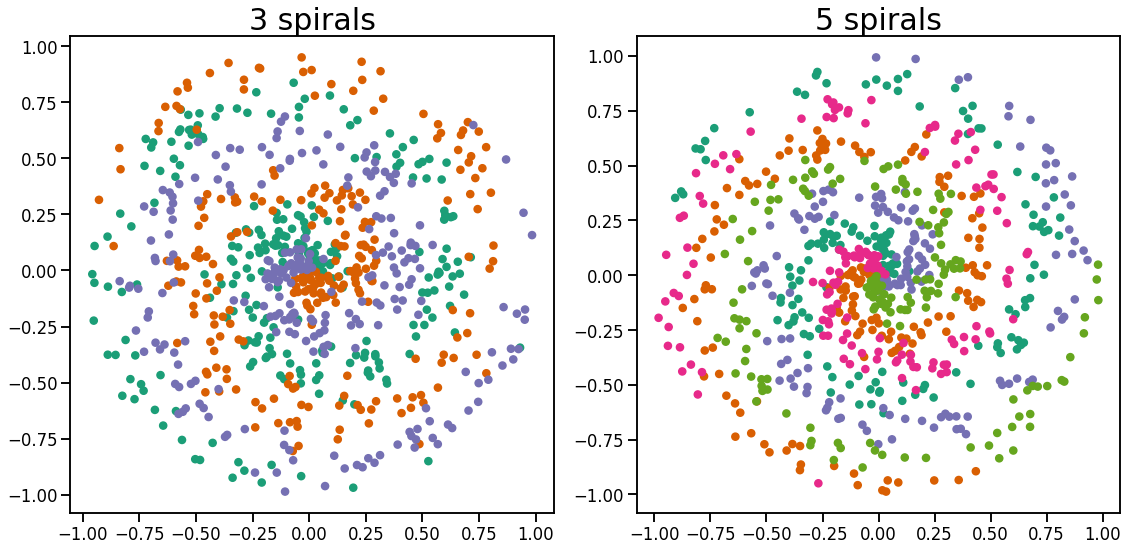

In [72]:
spiral3, y_spiral3 = generate_spirals(750, 3, noise=0.8)
spiral5, y_spiral5 = generate_spirals(750, 5, noise=0.4)

colors = sns.color_palette('Dark2', n_colors=5)

fig, ax = plt.subplots(1,2, figsize=(16,8))

clr = [colors[i] for i in y_spiral3]
ax[0].scatter(spiral3[:, 0], spiral3[:, 1], c=clr, s=50)
# ax[0].set_xticks([])
# ax[0].set_yticks([])
ax[0].set_title('3 spirals', fontsize=30)
# ax[0].axis('off')

clr = [colors[i] for i in y_spiral5]
ax[1].scatter(spiral5[:, 0], spiral5[:, 1], c=clr, s=50)
# ax[1].set_xticks([])
# ax[1].set_yticks([])
ax[1].set_title('5 spirals', fontsize=30)
# ax[1].axis('off')

plt.tight_layout()

In [ ]:
# j = dat["15_15"]
j = errors_all["15_60"]
[np.mean(j[:,i]) for i in range(3)]

In [ ]:
[np.mean(np.array(errors)[:,i]) for i in range(3)]

In [ ]:
for i in [0,1]:
    print(np.mean(j[:,2]) / np.mean(j[:,i]))

In [ ]:
# indices of NaNs
print(np.sum(np.isnan(errors_all_0_simple_param['0_90'])))
errors_all_0_simple_param['0_90_withNans'] = errors_all_0_simple_param['0_90']
errors_all_0_simple_param['0_90'] = errors_all_0_simple_param['0_90_withNans'][~np.isnan(errors_all_0_simple_param['0_90_withNans']).any(axis=1)]


In [ ]:
# indices of NaNs
deg1 = 0; deg2 = 75
print(np.sum(np.isnan(errors_all_0_more_param[str(deg1)+'_'+str(deg2)])))
errors_all_0_more_param[str(deg1)+'_'+str(deg2)+'_withNans'] = errors_all_0_more_param[str(deg1)+'_'+str(deg2)]
errors_all_0_more_param[str(deg1)+'_'+str(deg2)] = errors_all_0_more_param[str(deg1)+'_'+str(deg2)+'_withNans'][~np.isnan(errors_all_0_more_param[str(deg1)+'_'+str(deg2)+'_withNans']).any(axis=1)]


In [ ]:
angle_sweep = [15,30,45,60,75,90,105]
mean_te = np.empty((len(angle_sweep), 2))
for idx in range(len(angle_sweep)):
    name = "15_" + str(angle_sweep[idx])
    j = errors_all_15_simple_param[name]
    mean_te[idx, 0] = np.mean(j[:,2]) / np.mean(j[:,0])
    mean_te[idx, 1] = np.mean(j[:,2]) / np.mean(j[:,1])
    
print(mean_te)

In [66]:
angle_sweep = [15,30,45,60,75,90]
mean_te = np.empty((len(angle_sweep), 2))
for idx in range(len(angle_sweep)):
    name = "0_" + str(angle_sweep[idx])
    j = errors_all[name]
    mean_te[idx, 0] = np.mean(j[:,2]) / np.mean(j[:,0])
    mean_te[idx, 1] = np.mean(j[:,2]) / np.mean(j[:,1])
    
print(mean_te)

[[1.08047559 1.09829231]
 [1.02840712 1.07282838]
 [0.96731519 1.03410374]
 [0.93506304 1.00423729]
 [0.92468747 0.92524444]
 [0.93641738 0.83406505]]


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
colors = sns.color_palette("Dark2", n_colors=2)
ax.plot(np.array(angle_sweep[:-2])-15, mean_te[:-2,0], linewidth = 3, label="L2F")
ax.plot(np.array(angle_sweep[:-2])-15, mean_te[:-2,1], linewidth = 3, label="SimpleElastix")
ax.set_xticks(range(0,91,10))
ax.set_xlabel('Task2 Net Angle of Rotation (Degrees)')
ax.set_ylabel('Backward Transfer Efficiency (XOR)')
ax.hlines(1, 0,90, colors='gray', linestyles='dashed',linewidth=1.5)
plt.legend()
plt.title('Task1 = 15deg RXOR')
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

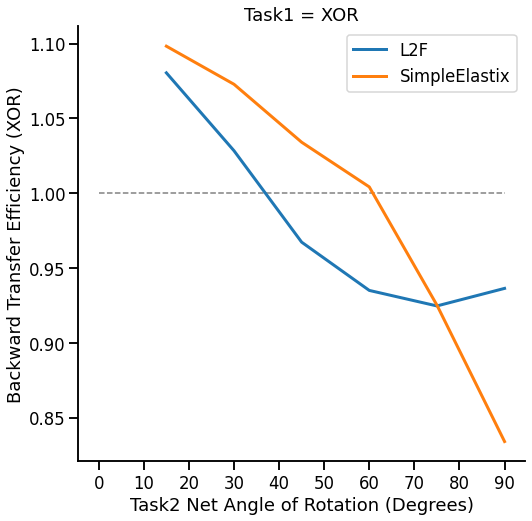

In [67]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
colors = sns.color_palette("Dark2", n_colors=2)
ax.plot(np.array(angle_sweep), mean_te[:,0], linewidth = 3, label="L2F")
ax.plot(np.array(angle_sweep), mean_te[:,1], linewidth = 3, label="SimpleElastix")
ax.set_xticks(range(0,91,10))
ax.set_xlabel('Task2 Net Angle of Rotation (Degrees)')
ax.set_ylabel('Backward Transfer Efficiency (XOR)')
ax.hlines(1, 0,90, colors='gray', linestyles='dashed',linewidth=1.5)
plt.legend()
plt.title("Task1 = XOR")
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
colors = sns.color_palette("Dark2", n_colors=2)
ax.plot(np.array(angle_sweep)-15, mean_te[:,0], linewidth = 3, label="SimpleElastix")
ax.plot(np.array(angle_sweep)-15, mean_te[:,1], linewidth = 3, label="L2F")
ax.set_xticks(range(0,91,10))
ax.set_xlabel('Angle of Rotation (Degrees)')
ax.set_ylabel('Backward Transfer Efficiency (XOR)')
ax.hlines(1, 0,90, colors='gray', linestyles='dashed',linewidth=1.5)
plt.legend()
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
colors = sns.color_palette("Dark2", n_colors=2)
ax.plot(np.array(angle_sweep), mean_te[:,0], linewidth = 3, label="SimpleElastix")
ax.plot(np.array(angle_sweep), mean_te[:,1], linewidth = 3, label="L2F")
ax.set_xticks(range(0,91,10))
ax.set_xlabel('Angle of Rotation (Degrees)')
ax.set_ylabel('Backward Transfer Efficiency (XOR)')
ax.hlines(1, 0,90, colors='gray', linestyles='dashed',linewidth=1.5)
plt.legend()
plt.title("More  ParamMap; Task1 = XOR")
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)